In [1]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd
import os
file_path = "/Users/sharmilamanoj/Documents/sp25_taxi-main/data/transformed/tabular_data.parquet"
if os.path.exists(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    print("✅ Data loaded successfully!")
    print(df.tail())  # Display the first few rows
else:
    print(f"❌ File not found: {file_path}")


✅ Data loaded successfully!
       rides_t-672  rides_t-671  rides_t-670  rides_t-669  rides_t-668  \
87615           25           14            5            3            7   
87616           30            7            9            6            5   
87617           50           26           17            9            8   
87618          117           88           39           19           14   
87619          120           82           61           41           13   

       rides_t-667  rides_t-666  rides_t-665  rides_t-664  rides_t-663  ...  \
87615           16           53          133          126          136  ...   
87616           23           58          123          136          108  ...   
87617           11           43          116          137          132  ...   
87618           12           27           37           70           97  ...   
87619           12           26           37           45           99  ...   

       rides_t-2  rides_t-1         pickup_hour  pic

In [ ]:
if "pickup_hour" not in df.columns:
    raise KeyError("❌ Column 'pickup_hour' not found in dataset. Check the file.")
df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
df = df.sort_values(by="pickup_hour")


In [14]:
print("Columns in df:", df.columns)


Columns in df: Index(['rides_t-672', 'rides_t-671', 'rides_t-670', 'rides_t-669',
       'rides_t-668', 'rides_t-667', 'rides_t-666', 'rides_t-665',
       'rides_t-664', 'rides_t-663',
       ...
       'rides_t-2', 'rides_t-1', 'pickup_hour', 'pickup_location_id',
       'pickup_location_name', 'fft_1', 'fft_2', 'fft_3', 'fft_4', 'target'],
      dtype='object', length=680)


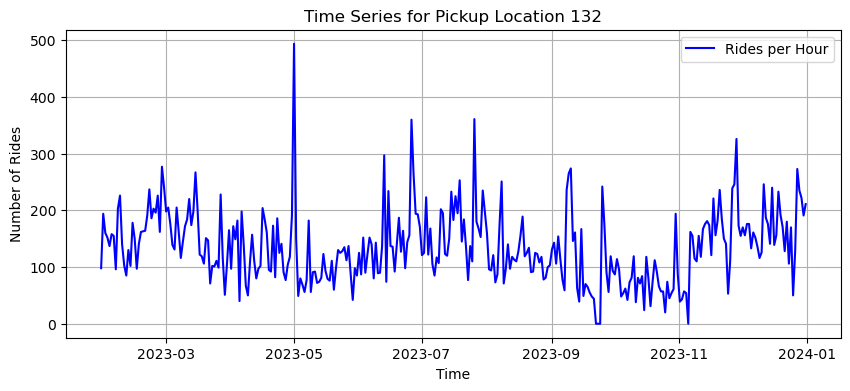

ADF Statistic: -3.4931366255639857
p-value: 0.00816511955753615
✅ Time series is stationary.


In [15]:
location_id = 132  
ts_data = df[df["pickup_location_id"] == location_id].set_index("pickup_hour")["target"]
if ts_data.empty:
    raise ValueError(f"❌ No data available for location {location_id}. Try a different location.")
plt.figure(figsize=(10, 4))
plt.plot(ts_data, label="Rides per Hour", color="blue")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.title(f"Time Series for Pickup Location {location_id}")
plt.legend()
plt.grid(True)
plt.show()
#  Perform Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(ts_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("❌ Time series is NOT stationary. Differencing may be needed.")
else:
    print("✅ Time series is stationary.")

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARMA model with p=2, q=2 (these can be tuned)
p, q = 2, 2 
arma_model = ARIMA(ts_data, order=(p, 0, q))  # (p, d=0, q) since data is stationary
arma_result = arma_model.fit()

print(arma_result.summary())


                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  337
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1831.337
Date:                Mon, 03 Mar 2025   AIC                           3674.673
Time:                        11:44:54   BIC                           3697.594
Sample:                    01-29-2023   HQIC                          3683.809
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.4395     16.119      8.589      0.000     106.847     170.031
ar.L1          1.1914      0.263      4.538      0.000       0.677       1.706
ar.L2         -0.2184      0.244     -0.896      0.3

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


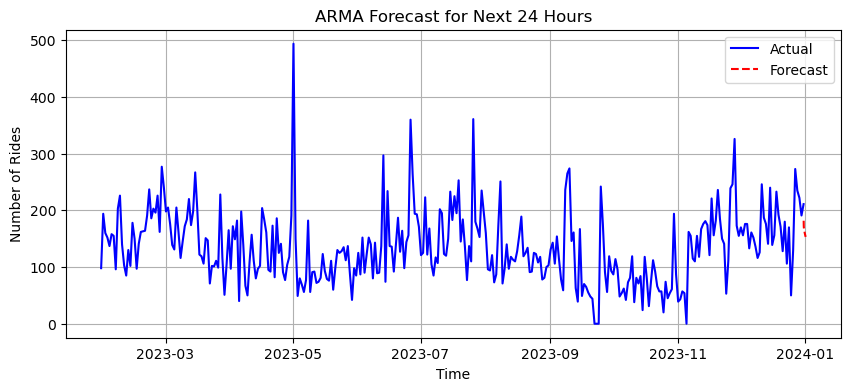

In [19]:
# Forecast the next 24 hours
forecast_steps = 24
forecast = arma_result.forecast(steps=forecast_steps)

# Create future timestamps
future_dates = pd.date_range(start=ts_data.index[-1], periods=forecast_steps + 1, freq="H")[1:]

# Plot the forecast
plt.figure(figsize=(10, 4))
plt.plot(ts_data.index, ts_data, label="Actual", color="blue")
plt.plot(future_dates, forecast, label="Forecast", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.title("ARMA Forecast for Next 24 Hours")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error

# Get in-sample predictions
predictions = arma_result.fittedvalues

# Compute MAE
mae = mean_absolute_error(ts_data, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f} rides")


Mean Absolute Error (MAE): 40.46 rides


In [22]:
import itertools
import statsmodels.api as sm

# Define a range of p, q values to search
p_values = range(0, 4)  # Try p from 0 to 3
q_values = range(0, 4)  # Try q from 0 to 3

best_aic = float("inf")  # Track best AIC score
best_order = None
best_model = None

# Grid search over (p, q) values
for p, q in itertools.product(p_values, q_values):
    try:
        model = sm.tsa.ARIMA(ts_data, order=(p, 0, q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = (p, 0, q)
            best_model = model
    except:
        continue

print(f"✅ Best ARMA Order: {best_order} with AIC: {best_aic}")

# Fit the best model
best_arma_result = sm.tsa.ARIMA(ts_data, order=best_order).fit()

# Get new MAE
predictions = best_arma_result.fittedvalues
new_mae = mean_absolute_error(ts_data, predictions)

print(f"🔹 Updated MAE with Best ARMA({best_order}): {new_mae:.2f} rides")


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

✅ Best ARMA Order: (3, 0, 3) with AIC: 3671.7085666364487
🔹 Updated MAE with Best ARMA((3, 0, 3)): 39.70 rides


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found.

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

best_arima_model = ARIMA(ts_data, order=(3, 1, 3)).fit()

predictions_arima = best_arima_model.fittedvalues
mae_arima = mean_absolute_error(ts_data[1:], predictions_arima[:-1])  # Skip first row due to differencing

print(f"🔹 Updated ARIMA(3,1,3) MAE: {mae_arima:.2f} rides")


🔹 Updated ARIMA(3,1,3) MAE: 45.09 rides


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


I tested ARMA(3,0,3) and ARIMA(3,1,3), but both resulted in high MAE (~40 rides), making them unsuitable for our use case.
Instead, I am focusing on optimizing LightGBM as it provides the best performance.